In [4]:
from ultralytics import YOLO

# Load the YOLO11 model
model = YOLO("/data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights/best.pt")  # load a custom model


# Export the model to ONNX format
model.export(format="onnx")  # creates 'yolo11n.onnx'

Ultralytics 8.3.37 🚀 Python-3.11.10 torch-2.5.1+cu124 CPU (Intel Xeon Platinum 8352V 2.10GHz)


YOLO11x-seg summary (fused): 491 layers, 62,003,283 parameters, 0 gradients, 318.5 GFLOPs

PyTorch: starting from '/data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights/best.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) ((1, 37, 33600), (1, 32, 320, 320)) (119.1 MB)

ONNX: starting export with onnx 1.16.0 opset 19...
ONNX: slimming with onnxslim 0.1.42...
ONNX: export success ✅ 5.4s, saved as '/data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights/best.onnx' (237.3 MB)

Export complete (9.2s)
Results saved to /data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights
Predict:         yolo predict task=segment model=/data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights/best.onnx imgsz=1280  
Validate:        yolo val task=segment model=/data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights/best.onnx imgsz=1280 data=./data.yaml  
Visualize:       https://netron.app


'/data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights/best.onnx'

In [16]:
from ultralytics import YOLO
model = YOLO("/data/yan/track/runs/segment/yolov11_WormCNN-HTT34/weights/best.pt")  # load a custom model



####CONFIG
video_path = '/data/yan/track/vedio/d4-2TS-20241126211046213.avi'
suffix='d4-2'
csv_filename = f"./results/{suffix}_worm_trajectories.csv"
####


In [17]:
from ultralytics import YOLO
import cv2
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
import csv
# 视频路径
# 请确保视频路径正确，并且模型与视频的分辨率匹配
cap = cv2.VideoCapture(video_path)

# 检查视频是否成功打开
if cap.isOpened():
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"视频分辨率: 宽={frame_width}, 高={frame_height}")
    print(f"总帧数: {total_frames}, FPS: {fps}")
else:
    print("错误: 无法打开视频。")
    exit()

# 初始化追踪变量
trajectories = defaultdict(list)  # {worm_id: [(frame, Centroid_X, Centroid_Y, A_x, A_y, B_x, B_y), ...]}
next_worm_id = 0
worm_positions = {}  # {worm_id: (Centroid_X, Centroid_Y)}

# 距离阈值（像素），用于匹配帧之间的线虫
base_distance_threshold = 200

# 指数平滑参数，用于减少关键点的抖动
alpha = 0.01  # 平滑因子，范围在0.0到1.0之间

def smooth_coordinates(worm_id, new_centroid, new_A, new_B):
    """
    对质心和关键点A、B进行指数平滑，减少抖动。
    """
    if worm_id in worm_positions:
        prev_centroid = worm_positions[worm_id]['centroid']
        prev_A = worm_positions[worm_id]['A']
        prev_B = worm_positions[worm_id]['B']
        
        smoothed_centroid_x = alpha * prev_centroid[0] + (1 - alpha) * new_centroid[0]
        smoothed_centroid_y = alpha * prev_centroid[1] + (1 - alpha) * new_centroid[1]
        
        smoothed_A_x = alpha * prev_A[0] + (1 - alpha) * new_A[0]
        smoothed_A_y = alpha * prev_A[1] + (1 - alpha) * new_A[1]
        
        smoothed_B_x = alpha * prev_B[0] + (1 - alpha) * new_B[0]
        smoothed_B_y = alpha * prev_B[1] + (1 - alpha) * new_B[1]
        
        smoothed_centroid = (int(smoothed_centroid_x), int(smoothed_centroid_y))
        smoothed_A = (int(smoothed_A_x), int(smoothed_A_y))
        smoothed_B = (int(smoothed_B_x), int(smoothed_B_y))
        
        return smoothed_centroid, smoothed_A, smoothed_B
    else:
        return new_centroid, new_A, new_B

def get_keypoints(mask, mask_width, mask_height, frame_width, frame_height):
    """
    基于mask计算三个关键点：质心（Centroid）、关键点A和关键点B。
    通过PCA找到主轴方向，并在主轴两端确定两个点A和B。
    """
    # 查找轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None  # 如果未找到轮廓，返回None
    
    # 假设最大的轮廓对应线虫
    contour = max(contours, key=cv2.contourArea)
    if len(contour) < 2:
        return None, None, None  # 轮廓点不足
    
    # 计算质心
    moments = cv2.moments(mask)
    if moments["m00"] == 0:
        return None, None, None  # 防止除以零
    cx = int(moments["m10"] / moments["m00"])
    cy = int(moments["m01"] / moments["m00"])
    
    # 将mask坐标转换为视频分辨率坐标
    cx = int(cx * (frame_width / mask_width))
    cy = int(cy * (frame_height / mask_height))
    centroid = (cx, cy)
    
    # 执行PCA
    contour_points = contour.reshape(-1, 2).astype(np.float32)
    mean, eigenvectors = cv2.PCACompute(contour_points, mean=None, maxComponents=2)
    
    # 主方向向量
    direction = eigenvectors[0]
    
    # 计算主轴方向上的两个端点
    max_distance = np.max(np.linalg.norm(contour_points - mean, axis=1))
    distance = max_distance  # 可以根据需要调整比例
    
    # 关键点A和B
    A = (
        int((mean[0][0] + direction[0] * distance) * (frame_width / mask_width)),
        int((mean[0][1] + direction[1] * distance) * (frame_height / mask_height))
    )
    B = (
        int((mean[0][0] - direction[0] * distance) * (frame_width / mask_width)),
        int((mean[0][1] - direction[1] * distance) * (frame_height / mask_height))
    )
    
    return centroid, A, B


# 使用YOLO进行预测，并获取结果流
results = model.predict(
    video_path,
    line_width=4,
    imgsz=1280,
    conf=0.3,
    save=True,
    stream=True,
    device=0,
    # batch=12
    # vid_stride=10,
)

# 逐帧处理视频
for frame_idx, result in enumerate(results):
    print(f"正在处理第 {frame_idx} 帧...")
    
    current_keypoints = []
    
    # 检查是否有分割结果
    if result.masks is None or len(result.masks.data) == 0:
        print(f"第 {frame_idx} 帧未检测到任何mask。")
        worm_positions.clear()  # 如果未检测到线虫，清空当前位置
        continue
    
    masks = result.masks.data
    mask_width = masks[0].shape[1]
    mask_height = masks[0].shape[0]
    
    for mask in masks:
        mask_numpy = mask.cpu().numpy().astype('uint8')  # 转换为numpy格式
        centroid, A, B = get_keypoints(mask_numpy, mask_width, mask_height, frame_width, frame_height)
        if centroid and A and B:
            current_keypoints.append((centroid, A, B))
        else:
            print(f"第 {frame_idx} 帧中的一个mask未能生成关键点。")

    
    if frame_idx == 0:
        # 初始化线虫位置和轨迹
        for keypoints in current_keypoints:
            centroid, A, B = keypoints
            worm_positions[next_worm_id] = {
                'centroid': centroid,
                'A': A,
                'B': B
            }
            trajectories[next_worm_id].append((frame_idx, centroid[0], centroid[1], A[0], A[1], B[0], B[1]))
            next_worm_id += 1
    else:
        # 获取之前的线虫ID和质心位置
        prev_worm_ids = list(worm_positions.keys())
        prev_centroids = [worm_positions[wid]['centroid'] for wid in prev_worm_ids]
        
        # 当前帧的质心
        current_centroids = [kp[0] for kp in current_keypoints]
        
        # 计算距离矩阵
        if len(prev_centroids) > 0 and len(current_centroids) > 0:
            distances = cdist(prev_centroids, current_centroids)
            # 使用匈牙利算法进行最优匹配
            row_indices, col_indices = linear_sum_assignment(distances)
            
            matched_worm_ids = set()
            matched_cols = set()
            
            for row, col in zip(row_indices, col_indices):
                distance = distances[row, col]
                if distance < base_distance_threshold:
                    worm_id = prev_worm_ids[row]
                    centroid, A, B = current_keypoints[col]
                    smoothed_centroid, smoothed_A, smoothed_B = smooth_coordinates(worm_id, centroid, A, B)
                    worm_positions[worm_id] = {
                        'centroid': smoothed_centroid,
                        'A': smoothed_A,
                        'B': smoothed_B
                    }
                    trajectories[worm_id].append((frame_idx, smoothed_centroid[0], smoothed_centroid[1],
                                                  smoothed_A[0], smoothed_A[1], smoothed_B[0], smoothed_B[1]))
                    matched_worm_ids.add(worm_id)
                    matched_cols.add(col)
                else:
                    # 距离过大，不进行匹配
                    pass
            
            # 移除未匹配的之前的线虫ID（可选：可保持几帧未匹配状态）
            unmatched_worm_ids = set(prev_worm_ids) - matched_worm_ids
            for worm_id in unmatched_worm_ids:
                del worm_positions[worm_id]
            
            # 为未匹配的当前关键点分配新的ID
            for idx, keypoints in enumerate(current_keypoints):
                if idx not in matched_cols:
                    centroid, A, B = keypoints
                    smoothed_centroid, smoothed_A, smoothed_B = smooth_coordinates(next_worm_id, centroid, A, B)
                    worm_positions[next_worm_id] = {
                        'centroid': smoothed_centroid,
                        'A': smoothed_A,
                        'B': smoothed_B
                    }
                    trajectories[next_worm_id].append((frame_idx, smoothed_centroid[0], smoothed_centroid[1],
                                                      smoothed_A[0], smoothed_A[1], smoothed_B[0], smoothed_B[1]))
                    next_worm_id += 1
        else:
            # 如果没有之前的线虫或当前没有检测到线虫，直接初始化
            for keypoints in current_keypoints:
                centroid, A, B = keypoints
                worm_positions[next_worm_id] = {
                    'centroid': centroid,
                    'A': A,
                    'B': B
                }
                trajectories[next_worm_id].append((frame_idx, centroid[0], centroid[1], A[0], A[1], B[0], B[1]))
                next_worm_id += 1

# 保存轨迹数据到CSV文件

with open(csv_filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["WormID", "Frame", "Centroid_X", "Centroid_Y", "KeypointA_X", "KeypointA_Y", "KeypointB_X", "KeypointB_Y"])
    for worm_id, trajectory in trajectories.items():
        for data in trajectory:
            writer.writerow([worm_id] + list(data))

print(f"轨迹已保存到 '{csv_filename}'。")



视频分辨率: 宽=1600, 高=1200
总帧数: 15249, FPS: 28.8

video 1/1 (frame 1/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 25.0ms
正在处理第 0 帧...
video 1/1 (frame 2/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 24.4ms
正在处理第 1 帧...
video 1/1 (frame 3/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 24.4ms
正在处理第 2 帧...
video 1/1 (frame 4/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 24.4ms
正在处理第 3 帧...
video 1/1 (frame 5/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 24.4ms
正在处理第 4 帧...
video 1/1 (frame 6/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 23.2ms
正在处理第 5 帧...
video 1/1 (frame 7/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 23.3ms
正在处理第 6 帧...
video 1/1 (frame 8/15249) /data/yan/track/vedio/d4-2TS-20241126211046213.avi: 960x1280 2 Celeganss, 23.2ms
正在处理第 7 

In [18]:
import pandas as pd
import numpy as np
import cv2

# 获取视频帧率
video_capture = cv2.VideoCapture(video_path)
fps = video_capture.get(cv2.CAP_PROP_FPS)
video_capture.release()
if fps <= 0:
    raise ValueError("无法获取视频帧率，请检查视频路径或格式。")

# 计算每帧的时间差
frame_time_diff = 1 / fps

# 读取 CSV 文件
file_path = csv_filename  # 替换为您的文件路径
data = pd.read_csv(file_path)

# 统计每个 WormID 的累计 Frame
worm_frame_count = data.groupby('WormID')['Frame'].count()

# 筛选累计 Frame > 1000 的 WormID
valid_worms = worm_frame_count[worm_frame_count > 1000].index
filtered_data = data[data['WormID'].isin(valid_worms)]

# 对 WormID 进行重新编号
worm_id_map = {old_id: new_id for new_id, old_id in enumerate(filtered_data['WormID'].unique(), start=1)}
filtered_data['WormID'] = filtered_data['WormID'].map(worm_id_map)

# 计算质心速度（两帧之间的欧几里得距离除以时间差）
filtered_data['Centroid_Velocity'] = np.sqrt(
    filtered_data.groupby('WormID')['Centroid_X'].diff()**2 +
    filtered_data.groupby('WormID')['Centroid_Y'].diff()**2
) / frame_time_diff
filtered_data['Centroid_Velocity'] = filtered_data['Centroid_Velocity'].fillna(0)

# 计算质心加速度（速度变化率除以时间差）
filtered_data['Centroid_Acceleration'] = (
    filtered_data.groupby('WormID')['Centroid_Velocity'].diff()
) / frame_time_diff
filtered_data['Centroid_Acceleration'] = filtered_data['Centroid_Acceleration'].fillna(0)

# 保存结果到新 CSV 文件
output_path = f"results/{suffix}_processed_trajectories.csv"  # 替换为输出文件路径
filtered_data.to_csv(output_path, index=False)

print(f"数据处理完成，结果已保存到 {output_path}")


数据处理完成，结果已保存到 results/d4-2_processed_trajectories.csv


/tmp/ipykernel_28113/4218253406.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['WormID'] = filtered_data['WormID'].map(worm_id_map)
/tmp/ipykernel_28113/4218253406.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Centroid_Velocity'] = np.sqrt(
/tmp/ipykernel_28113/4218253406.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [19]:
import pandas as pd
import cv2
import imageio
import numpy as np
from PIL import Image
from matplotlib import cm

# 参数设置
csv_file = f'/data/yan/track/results/{suffix}_processed_trajectories.csv'  # 轨迹数据文件
output_gif_no_trace = f"./results/{suffix}_processesed_trajectories_no_trace.gif"  # 输出 GIF（无轨迹）文件名
output_gif_with_trace = f"./results/{suffix}_processesed_trajectories_with_trace.gif"  # 输出 GIF（实时轨迹）文件名

# 定义目标分辨率
target_width, target_height = 400, 300  

# 定义采样率
sampling_rate = 25  # 每隔一帧处理一次

# 读取轨迹数据
data = pd.read_csv(csv_file)

# 提取帧数范围
max_frame = data["Frame"].max()

# 打开视频以提取背景帧
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Cannot open video.")
    exit()

# 获取原始视频帧大小
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Original Video Resolution: Width={original_width}, Height={original_height}")

# 初始化 GIF 帧列表
frames_no_trace = []  # 无轨迹的帧
frames_with_trace = []  # 实时轨迹的帧

# 初始化轨迹记录
worm_traces_centroid = {worm_id: [] for worm_id in data["WormID"].unique()}
worm_traces_A = {worm_id: [] for worm_id in data["WormID"].unique()}
worm_traces_B = {worm_id: [] for worm_id in data["WormID"].unique()}

# 定义颜色映射（使用 matplotlib colormap）
colormap = cm.get_cmap('viridis', 256)  # 可选择 'plasma', 'magma', 'inferno' 等
def get_color(worm_id, alpha=0.5):
    color = colormap(worm_id % 256)  # 归一化到 0-255
    return (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255), int(alpha * 255))

# 处理每一帧
for frame_idx in range(max_frame + 1):
    if frame_idx % sampling_rate != 0:
        # 跳过当前帧
        ret = cap.grab()
        if not ret:
            print(f"End of video reached at frame {frame_idx}.")
            break
        continue

    # 读取视频帧
    ret, frame = cap.read()
    if not ret:
        print(f"End of video reached at frame {frame_idx}.")
        break

    # 调整帧大小到目标分辨率
    frame_resized = cv2.resize(frame, (target_width, target_height))

    # 提取当前帧的轨迹点
    current_data = data[data["Frame"] == frame_idx]

    # 绘制无轨迹的帧
    frame_no_trace = frame_resized.copy()

    # 绘制实时轨迹的帧
    frame_with_trace = frame_resized.copy()

    # 在帧中添加速度和加速度的可视化
    for _, row in current_data.iterrows():
        worm_id = int(row["WormID"])
        centroid_x, centroid_y = int(row["Centroid_X"]), int(row["Centroid_Y"])
        A_x, A_y = int(row["KeypointA_X"]), int(row["KeypointA_Y"])
        B_x, B_y = int(row["KeypointB_X"]), int(row["KeypointB_Y"])
        speed = row["Centroid_Velocity"]  # 从数据中读取速度
        acceleration = row["Centroid_Acceleration"]  # 从数据中读取加速度

        # 根据新的分辨率调整坐标
        centroid_x_resized = int(centroid_x * (target_width / original_width))
        centroid_y_resized = int(centroid_y * (target_height / original_height))
        A_x_resized = int(A_x * (target_width / original_width))
        A_y_resized = int(A_y * (target_height / original_height))
        B_x_resized = int(B_x * (target_width / original_width))
        B_y_resized = int(B_y * (target_height / original_height))

        # 获取颜色
        color = get_color(worm_id, alpha=0.8)
        centroid_color = color[:3]

        # 绘制速度和加速度文本
        if speed > 0:
            speed_text = f"v={speed:.2f} mm/s"
            text_size_speed = cv2.getTextSize(speed_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
            text_x_speed = centroid_x_resized + 5
            text_y_speed = centroid_y_resized + 15
            for frame in [frame_no_trace, frame_with_trace]:
                cv2.rectangle(frame,
                            (text_x_speed - 2, text_y_speed - text_size_speed[1] - 2),
                            (text_x_speed + text_size_speed[0] + 2, text_y_speed + 2),
                            (255, 0, 0), -1)  # 蓝色矩形
                cv2.putText(frame, speed_text, (text_x_speed, text_y_speed),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)  # 白色小字

        if acceleration > 0:
            acceleration_text = f"a={acceleration:.2f} mm/s²"
            text_size_accel = cv2.getTextSize(acceleration_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
            text_x_accel = centroid_x_resized + 5
            text_y_accel = text_y_speed + 15  # 加速度文本在速度文本下方
            for frame in [frame_no_trace, frame_with_trace]:
                cv2.rectangle(frame,
                            (text_x_accel - 2, text_y_accel - text_size_accel[1] - 2),
                            (text_x_accel + text_size_accel[0] + 2, text_y_accel + 2),
                            (0, 255, 0), -1)  # 绿色矩形
                cv2.putText(frame, acceleration_text, (text_x_accel, text_y_accel),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)  # 白色小字

        # 在有轨迹的帧中绘制实时轨迹
        worm_traces_centroid[worm_id].append((centroid_x_resized, centroid_y_resized))
        worm_traces_A[worm_id].append((A_x_resized, A_y_resized))
        worm_traces_B[worm_id].append((B_x_resized, B_y_resized))

        for trace_point in worm_traces_centroid[worm_id]:
            cv2.circle(frame_with_trace, trace_point, 1, centroid_color, -1)  # 质心轨迹
        for trace_point in worm_traces_A[worm_id]:
            cv2.circle(frame_with_trace, trace_point, 1, (0, 255, 0), -1)  # 关键点 A 轨迹
        for trace_point in worm_traces_B[worm_id]:
            cv2.circle(frame_with_trace, trace_point, 1, (255, 0, 0), -1)  # 关键点 B 轨迹

        # 在帧上标注 WormID
        cv2.putText(frame_with_trace, f"Worm {worm_id}", (centroid_x_resized + 5, centroid_y_resized - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, centroid_color, 1)

    # 在每帧上添加帧号
    cv2.putText(frame_no_trace, f"Frame: {frame_idx}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    cv2.putText(frame_with_trace, f"Frame: {frame_idx}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    # 转为 RGB 格式（OpenCV 默认是 BGR）
    frames_no_trace.append(cv2.cvtColor(frame_no_trace, cv2.COLOR_BGR2RGB))
    frames_with_trace.append(cv2.cvtColor(frame_with_trace, cv2.COLOR_BGR2RGB))

# 释放视频捕捉对象
cap.release()

# 生成 GIF
imageio.mimsave(output_gif_no_trace, frames_no_trace, fps=25, loop=0)  # 无轨迹，循环播放
imageio.mimsave(output_gif_with_trace, frames_with_trace, fps=25, loop=0)  # 实时轨迹，循环播放
print(f"GIFs saved: '{output_gif_no_trace}' and '{output_gif_with_trace}'")


Original Video Resolution: Width=1600, Height=1200


/tmp/ipykernel_28113/3393993091.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis', 256)  # 可选择 'plasma', 'magma', 'inferno' 等


GIFs saved: './results/d4-2_processesed_trajectories_no_trace.gif' and './results/d4-2_processesed_trajectories_with_trace.gif'


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载轨迹数据
file_path =  csv_file
# file_path = 'results/day1_worm_trajectories.csv'
data = pd.read_csv(file_path)

wormnum = 5

# 检查数据格式
required_columns = ['WormID', 'Frame', 'Centroid_X', 'Centroid_Y', 'KeypointA_X', 'KeypointA_Y', 'KeypointB_X', 'KeypointB_Y']
if not all(col in data.columns for col in required_columns):
    raise ValueError(f"CSV文件缺少必要列: {', '.join(required_columns)}")

# 打印 Frame 的范围
frame_min = data['Frame'].min()
frame_max = data['Frame'].max()
print(f"Time frame range: {frame_min} to {frame_max}")


# 选择前3个 WormID
selected_worms = data['WormID'].unique()[:wormnum]

# 创建子图：每个虫子一行，三个图分别显示质心轨迹、关键点 A 和关键点 B
fig, axes = plt.subplots(len(selected_worms), 3, figsize=(16, 16), sharex=True, sharey=True)

# 绘制每个 Worm 的轨迹
for i, worm_id in enumerate(selected_worms):
    worm_data = data[data['WormID'] == worm_id]

    # 绘制质心轨迹
    ax = axes[i, 0]
    scatter_centroid = ax.scatter(
        worm_data['Centroid_X'], worm_data['Centroid_Y'], c=worm_data['Frame'], cmap='plasma', s=1, alpha=0.8
    )
    ax.set_title(f"Worm {worm_id} Centroid", fontsize=12)
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 1200)
    ax.set_xlabel("X Coordinate", fontsize=10)
    ax.set_ylabel("Y Coordinate", fontsize=10)
    ax.grid(alpha=0.3)
    fig.colorbar(scatter_centroid, ax=ax, orientation='vertical', label='Frame (Time)')

    # 绘制关键点 A 轨迹
    ax = axes[i, 1]
    scatter_A = ax.scatter(
        worm_data['KeypointA_X'], worm_data['KeypointA_Y'], c=worm_data['Frame'], cmap='viridis', s=1, alpha=0.8
    )
    ax.set_title(f"Worm {worm_id} Keypoint A", fontsize=12)
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 1200)
    ax.set_xlabel("X Coordinate", fontsize=10)
    ax.set_ylabel("Y Coordinate", fontsize=10)
    ax.grid(alpha=0.3)
    fig.colorbar(scatter_A, ax=ax, orientation='vertical', label='Frame (Time)')

    # 绘制关键点 B 轨迹
    ax = axes[i, 2]
    scatter_B = ax.scatter(
        worm_data['KeypointB_X'], worm_data['KeypointB_Y'], c=worm_data['Frame'], cmap='cool', s=1, alpha=0.8
    )
    ax.set_title(f"Worm {worm_id} Keypoint B", fontsize=12)
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 1200)
    ax.set_xlabel("X Coordinate", fontsize=10)
    ax.set_ylabel("Y Coordinate", fontsize=10)
    ax.grid(alpha=0.3)
    fig.colorbar(scatter_B, ax=ax, orientation='vertical', label='Frame (Time)')

# 调整布局并保存
plt.tight_layout()
output_path = f"results/{suffix}_trajectories_grouped_by_keypoints.png"
# output_path = f"results/day1_trajectories_grouped_by_keypoints.png"
plt.savefig(output_path, dpi=600)
plt.close()

print(f"组图已成功保存至 {output_path}")


Time frame range: 0 to 12287
组图已成功保存至 results/d4-2_trajectories_grouped_by_keypoints.png


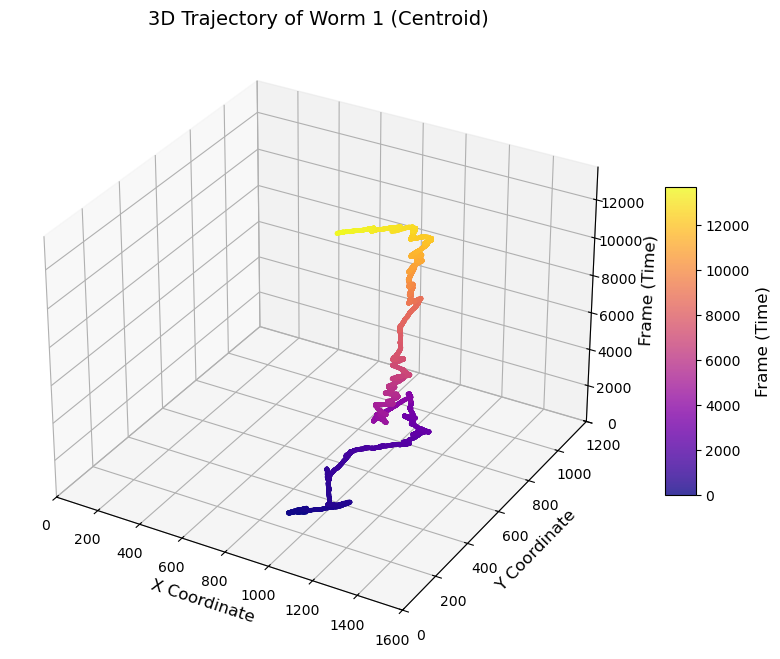

Worm 1 的3D轨迹图已保存至 results/worm1_trajectory_3D.png


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 读取数据
file_path = 'results/day1_worm_trajectories.csv'  # 替换为实际路径
data = pd.read_csv(file_path)

# 检查是否有必要的列
required_columns = ['WormID', 'Frame', 'Centroid_X', 'Centroid_Y']
if not all(col in data.columns for col in required_columns):
    raise ValueError(f"CSV文件缺少必要列: {', '.join(required_columns)}")

# 筛选 Worm1 数据
worm1_data = data[data['WormID'] == 1]

# 创建3D图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制轨迹点
scatter = ax.scatter(
    worm1_data['Centroid_X'],  # X坐标
    worm1_data['Centroid_Y'],  # Y坐标
    worm1_data['Frame'],       # Z坐标
    c=worm1_data['Frame'],     # 按帧数颜色变化
    cmap='plasma',             # 配色方案
    s=5,                       # 点的大小
    alpha=0.8                  # 透明度
)

# 添加颜色条
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Frame (Time)', fontsize=12)

# 设置标题和轴标签
ax.set_title("3D Trajectory of Worm 1 (Centroid)", fontsize=14)
ax.set_xlabel("X Coordinate", fontsize=12)
ax.set_ylabel("Y Coordinate", fontsize=12)
ax.set_zlabel("Frame (Time)", fontsize=12)

# 设置轴的范围
ax.set_xlim(0, 1600)
ax.set_ylim(0, 1200)
ax.set_zlim(worm1_data['Frame'].min(), worm1_data['Frame'].max())

# 保存图像
output_path = "results/worm1_trajectory_3D.png"
plt.savefig(output_path, dpi=600)
plt.show()

print(f"Worm 1 的3D轨迹图已保存至 {output_path}")
